This notebook illustrates applications of monkey-patching in Python. It also demonstrates some cool applications of the [inspect](https://docs.python.org/3/library/inspect.html) module.

**Author:** Tom McTavish

**Date:** November 18, 2020

# Introduction

## Definition

Monkey-patching is the process of inserting code during run-time, modifying the running instance, without modifying the original code.

## WARNING:

Monkey-patching should be avoided in production. This is because the running instance of software should be explicit -- reflected by what is on disk. Monkey patching also makes assumptions of what is on disk and the running state. If that software changes, the patch may not work as intended.

## Applications during development

Monkey-patching with respect to Data Science workflows is useful when we want to:

  * **Dive deeper with running objects, especially library objects.** We may want to understand a particular object's method in more detail. While we can see the code using the `inspect` module, we may want to log activity to see internal workings.
  
  * **Accelerate iterative development.** During the enhancement of an object's method, the typical flow is to make a code change, reinstantiate the object, then call the object's method, and repeat as necessary. For many objects, this is not problematic, but say you have a model that takes time to train. It can be quite tedious to retrain with each instantiation. As well, if the object is in Python module that we are updating, we may need to restart the Python kernel to reimport the module. This may also mean reloading large data sources, etc. 

We will look at these two scenarios, but first, let's look at a basic template.

# Monkey Patch Instance Method Template

In [1]:
import types

class MyClass:
    def class_func(self):
        print("class_func")
        
def patch_func(self):
    print("patch_func")

# Make 2 instances of MyClass
obj = MyClass()
obj2 = MyClass()

# Modify `class_func()` in the first instance
obj.class_func = types.MethodType(patch_func, obj)

# Call `class_func()` in both objects
obj.class_func()  # Calls our patch
obj2.class_func()  # Calls the original

patch_func
class_func


The template above is the basic technique. Below, we show some applications.

# Examples

## Monkey Patching during iterative model development

In the following example, we show how we can apply monkey patching to an already-trained model. This allows us to fix bugs, make modifications, or add attributes to an existing model without having to retrain it to utilize the code changes. Ultimately, when we are finished, we should retrain the model completely. But this demo is to show how we can do development on a trained model.

This example uses DHI's Match Team [dsmatch](https://bitbucket.org/dhigroupinc/dhi-match-datascience/src/master/) library and the [efc-ensemble-3dim-20201103](https://bitbucket.org/dhigroupinc/dhi-match-models/src/master/efc-ensemble-3dim-20201103/) model. The cell below ensures specific versions of the packages so the model will run correctly.

In [2]:
!pip install --upgrade pip
!pip install --upgrade tqdm

!pip install -e git+ssh://git@bitbucket.org/dhigroupinc/dhi-match-datascience.git@4164b8c#egg=dsmatch

!pip install beautifulsoup4==4.8.2
!pip install boto==2.49.0
!pip install boto3==1.16.9
!pip install botocore==1.19.9
!pip install contractions==0.0.25
!pip install ipywidgets==7.5.1
!pip install joblib==0.17.0
!pip install json5==0.9.1
!pip install jsonpath-ng==1.5.2
!pip install jsonschema==3.2.0
!pip install line-profiler==3.1.0
!pip install nltk==3.4.5
!pip install numpy==1.18.1
!pip install pandas==1.1.4
!pip install s3fs==0.4.2
!pip install s3transfer==0.3.3
!pip install scikit-image==0.16.2
!pip install scikit-learn==0.22.1
!pip install scipy==1.4.1

### Import packages and read data to send to the model.

In [3]:
import os
import sys
sys.path.insert(0, './src/dsmatch/')  # prepend sys.path with this dsmatch so it uses this one, not a different one.

import joblib
import pandas as pd

from dhi.dsmatch.sklearnmodeling.models.bgskillsoptimalassignment import BGSkills
from dhi.dsmatch.sklearnmodeling.models.ndimcostfidf import NDimCosTfidf
from dhi.dsmatch.sklearnmodeling.models.compositetransformer import CompositeTransformer, ModelPackage

from dhi.dsmatch.util.io import read_csv, load_joblib
from dhi.dsmatch import local_bucket, s3_ds_bucket

pd.set_option('display.max_columns', 200)

# Read in the data we'll use.
path = os.path.join('data', 'efc', 'unsupervised')
filename = 'validation-skills-20201030.csv'
df = read_csv(path, filename)

# The lists in the dataframe are intepreted as strings and not lists, we need to make them lists of strings.
idxs = df[df['job-data-bg_skills'].isnull()].index
df.loc[idxs, 'job-data-bg_skills'] = "[]"
df.loc[:, 'job-data-bg_skills'] = df.loc[:, 'job-data-bg_skills'].apply(eval)
idxs = df[df['resume-data-bg_skills'].isnull()].index
df.loc[idxs, 'resume-data-bg_skills'] = "[]"
df.loc[:, 'resume-data-bg_skills'] = df.loc[:, 'resume-data-bg_skills'].apply(eval)
df.set_index('row_id', inplace=True)
df.head()

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,job-title,job-description,current_job_title,resume,match_score,set,Source,Language,jdtext,resume_clean,job_description_clean,job_title_clean,job-data-bg_skills,resume-data-bg_skills
row_id,,,,,,,,,,,,,,
row_0000,"Aluminium Casting Specialist, Can Body Stock",Redstone Commodity Search are working with an ...,Aluminum designer and planning engineer,E D U C A T I O N\r\n\r\n Bachelor Degree in ...,3.0,train,NaN,en,NaN,e c n bachelor degre civil engin bülent ecevi...,redston commod search work intern metal produc...,aluminium cast specialist bodi stock.,"[3D Printing / Additive Manufacturing (AM), On...","[AutoCAD, Civil Engineering, ISO 9001 Standard..."
row_0001,Remittance Officer [Banking] (ID: 483271),Your key roles & responsibilities include: Ha...,Manger Operation,CAREER OBJECTIVE \r\n\r\n Seeking an opportun...,2.0,train,NaN,en,NaN,career object seek opportun career advanc chal...,key roles_and_respons includ handl daytoday tr...,remitt offic bank id 483271.,"[Communication Skills, Preparing Reports]","[Chinese, External Auditing, Global Positionin..."
row_0002,"Investment Banking Associate, Singapore based",Responsibilities would include: Supporting ...,Unit Manager,"STEVEN CHOOI HOONG KIT\r\n\r\n6, Tingkat Falim...",3.0,test,NaN,en,NaN,steven chooi hoong kit 6 tingkat falim 5 taman...,respons would includ support origin structur e...,invest bank associ singapor base.,"[Business Development, Customer Contact, Detai...","[Appointment Setting, Business Administration,..."
row_0003,Research Analyst - Systematic Macro,Responsibilities Managing all aspects of the ...,Quantitative Analyst,"2.4 Askew Building, 50 Bartholomew Close, Lon...",4.0,test,NaN,en,NaN,2_dot_4 askew build 50 bartholomew close londo...,respons manag aspect research process includ m...,research analyst systemat macro.,"[Data Collection, Detail-Oriented, Fixed Incom...","[Active Alpha Generation, Asset Management Ind..."
row_0004,"AVP, PRODUCT MANAGER",Product Development / Project Management Inno...,Senior product manager,Kuanzhao Huang \r\n\r\n⚫ 61210214 \r\n⚫ foonwo...,4.0,train,NaN,en,NaN,kuanzhao huang ⚫ 61210214 ⚫ foonwong511_at_gma...,product development_slash_project manag innov ...,avp product manag.,"[Communication Skills, Planning, Problem Solvi...","[Business Planning, Business Process, Business..."


### Load the model.

In [4]:
model = load_joblib(key=os.path.join('models', 'efc', 'unsupervised', 'efc-ensemble-3dim-20201103.joblib'))

### Send some data through the model.

Below, we select the subset of columns from the dataframe that the model is expecting and call its `transform()` method on the first row -- much like if we were asking for a prediction during runtime.

In [5]:
cols = ['resume', 'job-description', 'job-title', 'job-data-bg_skills', 'resume-data-bg_skills']
df_ = df.loc[:, cols]
resp = model.transform(df_.iloc[:1])
resp

,NDimCosTfidf|cossim-resume_job-description_cossim,NDimCosTfidf|cossim-resume_job-description_score,NDimCosTfidf|cossim-resume_job-description_resume_n_nonzero,NDimCosTfidf|cossim-resume_job-description_job-description_n_nonzero,NDimCosTfidf|cossim-resume_job-description_min_nonzero,NDimCosTfidf|cossim-resume_job-description_confidence,NDimCosTfidf|cossim-resume_job-title_cossim,NDimCosTfidf|cossim-resume_job-title_score,NDimCosTfidf|cossim-resume_job-title_resume_n_nonzero,NDimCosTfidf|cossim-resume_job-title_job-title_n_nonzero,NDimCosTfidf|cossim-resume_job-title_min_nonzero,NDimCosTfidf|cossim-resume_job-title_confidence,efc_bgskills_pairwise_optimal_assignment|n_skills_jd,efc_bgskills_pairwise_optimal_assignment|n_skills_res,efc_bgskills_pairwise_optimal_assignment|n_skills,efc_bgskills_pairwise_optimal_assignment|top-skills,efc_bgskills_pairwise_optimal_assignment|score,efc_bgskills_pairwise_optimal_assignment|confidence,confidence,NDimCosTfidf|cossim-resume_job-description_confimprt,NDimCosTfidf|cossim-resume_job-title_confimprt,efc_bgskills_pairwise_optimal_assignment|confimprt,confidence_total,NDimCosTfidf|cossim-resume_job-description_relative_weight,NDimCosTfidf|cossim-resume_job-title_relative_weight,efc_bgskills_pairwise_optimal_assignment|relative_weight,NDimCosTfidf|cossim-resume_job-description_contribution,NDimCosTfidf|cossim-resume_job-title_contribution,efc_bgskills_pairwise_optimal_assignment|contribution,score,quantile,pred
0,0.055976,0.0455203,120,78,78,0.486583,0,0,120,3,3,0.451188,15,42,15,[{'job_description': '3d printing / additive m...,0.468546,0.464739,0.467503,0.540324,0.367908,0.215578,1.12381,0.480796,0.327376,0.191828,0.021886,0,0.0898802,0.111766,0.09439,2


### Create a `detailed_predict()` function.

Let's create a `detailed_predict()` object method that converts this table into a nicely formatted JSON/dict structure.

In [6]:
def detailed_predict(self, X, **kwargs):
    """Call `transform()`, but yield results in a dict format.

    Args:
        X (DataFrame): Input data to transform.

    Returns:
        Dict: Overall results and each submodel results.
    """
    X = self.transform(X, **kwargs)  # Get our transformed dataframe
    return X.to_dict()  # Output as a dict

model.detailed_predict = types.MethodType(detailed_predict, model)  # Apply the patch
resp = model.detailed_predict(df_.iloc[:1])  # Call it
resp

{'NDimCosTfidf|cossim-resume_job-description_cossim': {0: 0.05597602135763841},
 'NDimCosTfidf|cossim-resume_job-description_score': {0: 0.04552030290124594},
 'NDimCosTfidf|cossim-resume_job-description_resume_n_nonzero': {0: 120.0},
 'NDimCosTfidf|cossim-resume_job-description_job-description_n_nonzero': {0: 78.0},
 'NDimCosTfidf|cossim-resume_job-description_min_nonzero': {0: 78.0},
 'NDimCosTfidf|cossim-resume_job-description_confidence': {0: 0.486582880967408},
 'NDimCosTfidf|cossim-resume_job-title_cossim': {0: 0.0},
 'NDimCosTfidf|cossim-resume_job-title_score': {0: 0.0},
 'NDimCosTfidf|cossim-resume_job-title_resume_n_nonzero': {0: 120.0},
 'NDimCosTfidf|cossim-resume_job-title_job-title_n_nonzero': {0: 3.0},
 'NDimCosTfidf|cossim-resume_job-title_min_nonzero': {0: 3.0},
 'NDimCosTfidf|cossim-resume_job-title_confidence': {0: 0.4511883639059736},
 'efc_bgskills_pairwise_optimal_assignment|n_skills_jd': {0: 15},
 'efc_bgskills_pairwise_optimal_assignment|n_skills_res': {0: 42},


### Interesting first stab, but not in the correct format...

Of course, the production team wanted the outputs in a different, more generalizable and readable format. Below is the final format of this method, which you can imagine required several iterations to tease column names apart, ignore some fields, and apply various formatting to arrive at the final desired output.

In [7]:
import numpy as np

def detailed_predict(self, X, **kwargs):
    """Call `transform()`, but yield results in a dict format.

    Args:
        X (DataFrame): Input data to transform.

    Returns:
        Dict: Overall results and each submodel results.
    """
    X = self.transform(X, **kwargs)
    score_cols = [c for c in X.columns if c.endswith('|score') or c.endswith('_score')]
    model_headers = [c[:-5] for c in score_cols]
    submodels = []
    for model_header in model_headers:
        if model_header[-1] == '|':
            model_name = model_header[:-1]
        else:
            splitted = model_header.split('|')
            model_name = splitted[-1][:-1]
        cols = [c for c in X.columns if c.startswith(model_header)]
        cols = [c for c in cols if not (c.endswith('score') 
                                        or c.endswith('confidence') 
                                        or c.endswith('relative_weight')
                                        or c.endswith('confimprt')
                                        or c.endswith('contribution'))]
        new_cols = [c[len(model_header):] for c in cols]
        explain = np.squeeze(
            X[cols].rename(columns=dict(zip(cols, new_cols)))\
            .to_dict(orient='records')).tolist()
        submodel = self.submodels_dict[model_name]
        submodels.append(dict(
            domain = submodel.domain,
            name = submodel.model.name,
            version = submodel.model.version,
            score = np.squeeze(X[model_header + 'score'].values).tolist(),
            confidence = np.squeeze(X[model_header + 'confidence'].values).tolist(),
            importance = submodel.importance,
            applied_weighting = np.squeeze(X[model_header + 'relative_weight'].values).tolist(),
            explain = explain
        ))

    # TODO: "overall_" fields below are temporary and should be removed when we have a true "overall" model
    # and where this ensemble model is a subset of the overall results.
    return dict(overall_class=np.squeeze(X['pred']).tolist(),
                overall_name=self.name,
                overall_version=self.version,
                overall_score=np.squeeze(X['quantile']).tolist(),
                ensemble_name=self.name,
                ensemble_score=np.squeeze(X['quantile']).tolist(),
                ensemble_class=np.squeeze(X['pred']).tolist(),
                ensemble_version=self.version,
                ensemble_confidence=np.squeeze(X['confidence']).tolist(),
                ensemble_submodels=submodels
            )

model.detailed_predict = types.MethodType(detailed_predict, model)  # Apply/update our patch
resp = model.detailed_predict(df_.iloc[:1])  # Call the method
resp

{'overall_class': 2,
 'overall_name': 'efc_ensemble_3Dim',
 'overall_version': '1.0.0',
 'overall_score': 0.09438960466986794,
 'ensemble_name': 'efc_ensemble_3Dim',
 'ensemble_score': 0.09438960466986794,
 'ensemble_class': 2,
 'ensemble_version': '1.0.0',
 'ensemble_confidence': 0.4675032721181305,
 'ensemble_submodels': [{'domain': 'text',
   'name': 'cossim-resume_job-description',
   'version': '1.0.0',
   'score': 0.04552030290124594,
   'confidence': 0.486582880967408,
   'importance': 0.6,
   'applied_weighting': 0.4807963423474216,
   'explain': {'cossim': 0.05597602135763841,
    'resume_n_nonzero': 120.0,
    'job-description_n_nonzero': 78.0,
    'min_nonzero': 78.0}},
  {'domain': 'text',
   'name': 'cossim-resume_job-title',
   'version': '1.0.0',
   'score': 0.0,
   'confidence': 0.4511883639059736,
   'importance': 0.3,
   'applied_weighting': 0.32737588835395437,
   'explain': {'cossim': 0.0,
    'resume_n_nonzero': 120.0,
    'job-title_n_nonzero': 3.0,
    'min_nonze

This concludes the illustration of adding functionality to an existing model where we have direct control of the source and can update that library code and retrain the model.

## Interrogating external code: An Sklearn example

In the next example, we will show how we can use the [inspect](https://docs.python.org/3/library/inspect.html) module and monkey patching to interrogate external code, in this case, an sklearn [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

Besides looking at the [source code](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/tree/_classes.py) to understand it, monkey patching permits us to insert print or log statements in the code, or to make modifications to see their impact.

In the following example, we are interested in seeing more how the DecisionTreeClassier's `fit()` function works. We will start by loading the [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set), fitting it, and visualizing the tree that is produced.

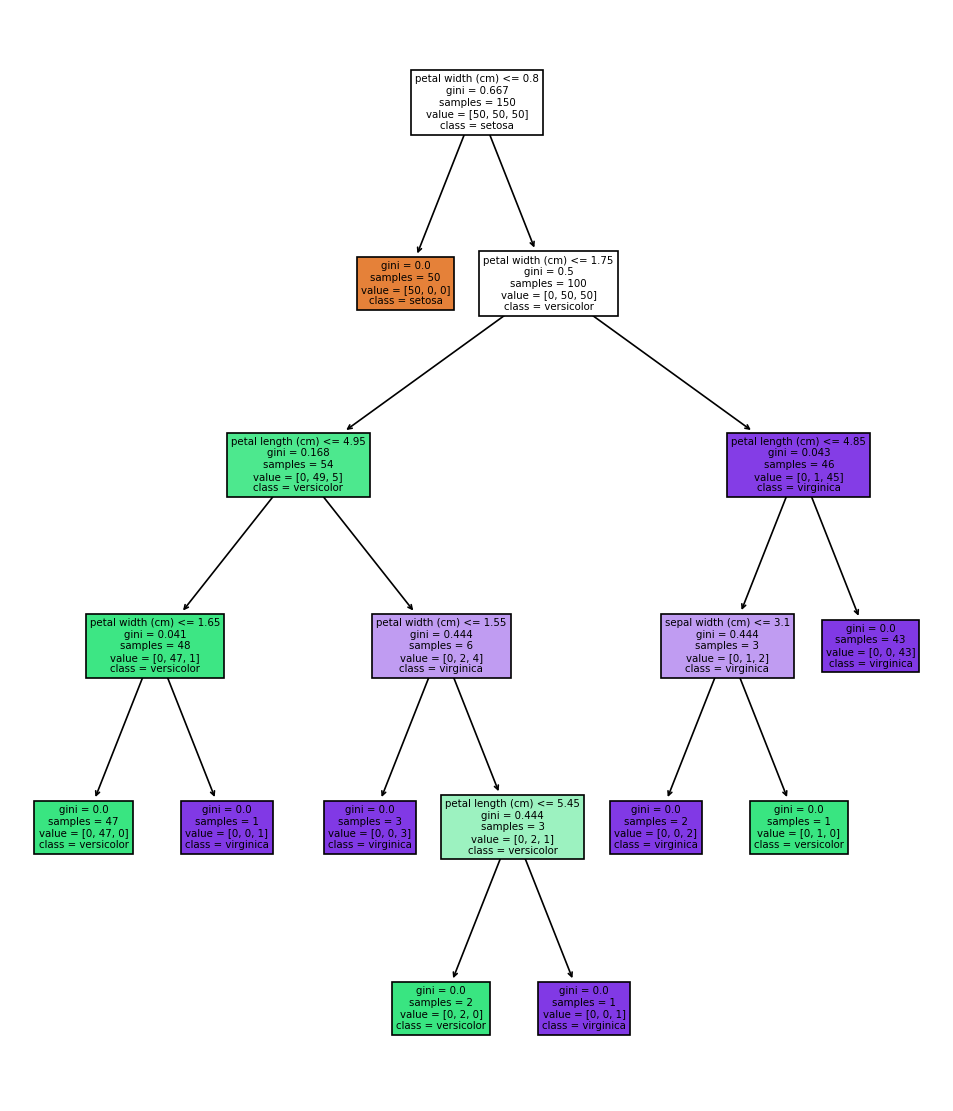

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Load data
iris = load_iris()
n_classes = len(iris.target_names)

plt.figure(figsize=(10, 12), dpi=120)
clf = DecisionTreeClassifier(random_state=0).fit(iris.data, iris.target)
plot_tree(clf, feature_names_out=iris.feature_names_out, class_names=iris.target_names, filled=True);

### Using `inspect` to see what that `fit()` function is doing.

To see the source code of the fit function, we can call `inspect.getsource()` with the class and its member function to see its output.

In [9]:
import inspect
print(inspect.getsource(DecisionTreeClassifier.fit))

    def fit(self, X, y, sample_weight=None, check_input=True,
            X_idx_sorted=None):
        """Build a decision tree classifier from the training set (X, y).

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csc_matrix``.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels) as integers or strings.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted. Splits
            that would create child nodes with net zero or negative weight are
            ignored while searching for a split in each node. Splits are also
            ignored if they would result in any single class carrying a
            neg

### Need to keep digging.

Hmmm, that is not very helpful. All it does is call its parent class's `fit()`. To dig into the method we need to determine what that parent class is.

In [10]:
print(inspect.getsource(DecisionTreeClassifier)[:100])

class DecisionTreeClassifier(ClassifierMixin, BaseDecisionTree):
    """A decision tree classifier.



It's a `BaseDecisionTree`, so let's look up its `fit()` method.

In [11]:
from sklearn.tree import BaseDecisionTree
print(inspect.getsource(BaseDecisionTree.fit))

    def fit(self, X, y, sample_weight=None, check_input=True,
            X_idx_sorted=None):

        random_state = check_random_state(self.random_state)

        if self.ccp_alpha < 0.0:
            raise ValueError("ccp_alpha must be greater than or equal to 0")

        if check_input:
            X = check_array(X, dtype=DTYPE, accept_sparse="csc")
            y = check_array(y, ensure_2d=False, dtype=None)
            if issparse(X):
                X.sort_indices()

                if X.indices.dtype != np.intc or X.indptr.dtype != np.intc:
                    raise ValueError("No support for np.int64 index based "
                                     "sparse matrices")

        # Determine output settings
        n_samples, self.n_features_ = X.shape
        is_classification = is_classifier(self)

        y = np.atleast_1d(y)
        expanded_class_weight = None

        if y.ndim == 1:
            # reshape is necessary to preserve the data contiguity against vs
            

### Modify `BaseDecisionTree.fit()`.

That is a long, ugly method. To be able to dive in as a monkey patch, we will copy the text above and insert a line to see that we can interact with it. We insert the `print(f'PATCH: n_samples={n_samples}')` code below. Execute the cell for this new fit function to take hold.

In [12]:
def fit(self, X, y, sample_weight=None, check_input=True,
        X_idx_sorted=None):

    random_state = check_random_state(self.random_state)

    if self.ccp_alpha < 0.0:
        raise ValueError("ccp_alpha must be greater than or equal to 0")

    if check_input:
        X = check_array(X, dtype=DTYPE, accept_sparse="csc")
        y = check_array(y, ensure_2d=False, dtype=None)
        if issparse(X):
            X.sort_indices()

            if X.indices.dtype != np.intc or X.indptr.dtype != np.intc:
                raise ValueError("No support for np.int64 index based "
                                 "sparse matrices")

    # Determine output settings
    n_samples, self.n_features_ = X.shape
    print(f'PATCH: n_samples={n_samples}')
    is_classification = is_classifier(self)

    y = np.atleast_1d(y)
    expanded_class_weight = None

    if y.ndim == 1:
        # reshape is necessary to preserve the data contiguity against vs
        # [:, np.newaxis] that does not.
        y = np.reshape(y, (-1, 1))

    self.n_outputs_ = y.shape[1]

    if is_classification:
        check_classification_targets(y)
        y = np.copy(y)

        self.classes_ = []
        self.n_classes_ = []

        if self.class_weight is not None:
            y_original = np.copy(y)

        y_encoded = np.zeros(y.shape, dtype=np.int)
        for k in range(self.n_outputs_):
            classes_k, y_encoded[:, k] = np.unique(y[:, k],
                                                   return_inverse=True)
            self.classes_.append(classes_k)
            self.n_classes_.append(classes_k.shape[0])
        y = y_encoded

        if self.class_weight is not None:
            expanded_class_weight = compute_sample_weight(
                self.class_weight, y_original)

        self.n_classes_ = np.array(self.n_classes_, dtype=np.intp)

    if getattr(y, "dtype", None) != DOUBLE or not y.flags.contiguous:
        y = np.ascontiguousarray(y, dtype=DOUBLE)

    # Check parameters
    max_depth = (np.iinfo(np.int32).max if self.max_depth is None
                 else self.max_depth)
    max_leaf_nodes = (-1 if self.max_leaf_nodes is None
                      else self.max_leaf_nodes)

    if isinstance(self.min_samples_leaf, numbers.Integral):
        if not 1 <= self.min_samples_leaf:
            raise ValueError("min_samples_leaf must be at least 1 "
                             "or in (0, 0.5], got %s"
                             % self.min_samples_leaf)
        min_samples_leaf = self.min_samples_leaf
    else:  # float
        if not 0. < self.min_samples_leaf <= 0.5:
            raise ValueError("min_samples_leaf must be at least 1 "
                             "or in (0, 0.5], got %s"
                             % self.min_samples_leaf)
        min_samples_leaf = int(ceil(self.min_samples_leaf * n_samples))

    if isinstance(self.min_samples_split, numbers.Integral):
        if not 2 <= self.min_samples_split:
            raise ValueError("min_samples_split must be an integer "
                             "greater than 1 or a float in (0.0, 1.0]; "
                             "got the integer %s"
                             % self.min_samples_split)
        min_samples_split = self.min_samples_split
    else:  # float
        if not 0. < self.min_samples_split <= 1.:
            raise ValueError("min_samples_split must be an integer "
                             "greater than 1 or a float in (0.0, 1.0]; "
                             "got the float %s"
                             % self.min_samples_split)
        min_samples_split = int(ceil(self.min_samples_split * n_samples))
        min_samples_split = max(2, min_samples_split)

    min_samples_split = max(min_samples_split, 2 * min_samples_leaf)

    if isinstance(self.max_features, str):
        if self.max_features == "auto":
            if is_classification:
                max_features = max(1, int(np.sqrt(self.n_features_)))
            else:
                max_features = self.n_features_
        elif self.max_features == "sqrt":
            max_features = max(1, int(np.sqrt(self.n_features_)))
        elif self.max_features == "log2":
            max_features = max(1, int(np.log2(self.n_features_)))
        else:
            raise ValueError("Invalid value for max_features. "
                             "Allowed string values are 'auto', "
                             "'sqrt' or 'log2'.")
    elif self.max_features is None:
        max_features = self.n_features_
    elif isinstance(self.max_features, numbers.Integral):
        max_features = self.max_features
    else:  # float
        if self.max_features > 0.0:
            max_features = max(1,
                               int(self.max_features * self.n_features_))
        else:
            max_features = 0

    self.max_features_ = max_features

    if len(y) != n_samples:
        raise ValueError("Number of labels=%d does not match "
                         "number of samples=%d" % (len(y), n_samples))
    if not 0 <= self.min_weight_fraction_leaf <= 0.5:
        raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
    if max_depth <= 0:
        raise ValueError("max_depth must be greater than zero. ")
    if not (0 < max_features <= self.n_features_):
        raise ValueError("max_features must be in (0, n_features]")
    if not isinstance(max_leaf_nodes, numbers.Integral):
        raise ValueError("max_leaf_nodes must be integral number but was "
                         "%r" % max_leaf_nodes)
    if -1 < max_leaf_nodes < 2:
        raise ValueError(("max_leaf_nodes {0} must be either None "
                          "or larger than 1").format(max_leaf_nodes))

    if sample_weight is not None:
        sample_weight = _check_sample_weight(sample_weight, X, DOUBLE)

    if expanded_class_weight is not None:
        if sample_weight is not None:
            sample_weight = sample_weight * expanded_class_weight
        else:
            sample_weight = expanded_class_weight

    # Set min_weight_leaf from min_weight_fraction_leaf
    if sample_weight is None:
        min_weight_leaf = (self.min_weight_fraction_leaf *
                           n_samples)
    else:
        min_weight_leaf = (self.min_weight_fraction_leaf *
                           np.sum(sample_weight))

    if self.min_impurity_split is not None:
        warnings.warn("The min_impurity_split parameter is deprecated. "
                      "Its default value will change from 1e-7 to 0 in "
                      "version 0.23, and it will be removed in 0.25. "
                      "Use the min_impurity_decrease parameter instead.",
                      FutureWarning)
        min_impurity_split = self.min_impurity_split
    else:
        min_impurity_split = 1e-7

    if min_impurity_split < 0.:
        raise ValueError("min_impurity_split must be greater than "
                         "or equal to 0")

    if self.min_impurity_decrease < 0.:
        raise ValueError("min_impurity_decrease must be greater than "
                         "or equal to 0")

    if self.presort != 'deprecated':
        warnings.warn("The parameter 'presort' is deprecated and has no "
                      "effect. It will be removed in v0.24. You can "
                      "suppress this warning by not passing any value "
                      "to the 'presort' parameter.",
                      FutureWarning)

    # Build tree
    criterion = self.criterion
    if not isinstance(criterion, Criterion):
        if is_classification:
            criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
                                                     self.n_classes_)
        else:
            criterion = CRITERIA_REG[self.criterion](self.n_outputs_,
                                                     n_samples)

    SPLITTERS = SPARSE_SPLITTERS if issparse(X) else DENSE_SPLITTERS

    splitter = self.splitter
    if not isinstance(self.splitter, Splitter):
        splitter = SPLITTERS[self.splitter](criterion,
                                            self.max_features_,
                                            min_samples_leaf,
                                            min_weight_leaf,
                                            random_state)

    if is_classifier(self):
        self.tree_ = Tree(self.n_features_,
                          self.n_classes_, self.n_outputs_)
    else:
        self.tree_ = Tree(self.n_features_,
                          # TODO: tree should't need this in this case
                          np.array([1] * self.n_outputs_, dtype=np.intp),
                          self.n_outputs_)

    # Use BestFirst if max_leaf_nodes given; use DepthFirst otherwise
    if max_leaf_nodes < 0:
        builder = DepthFirstTreeBuilder(splitter, min_samples_split,
                                        min_samples_leaf,
                                        min_weight_leaf,
                                        max_depth,
                                        self.min_impurity_decrease,
                                        min_impurity_split)
    else:
        builder = BestFirstTreeBuilder(splitter, min_samples_split,
                                       min_samples_leaf,
                                       min_weight_leaf,
                                       max_depth,
                                       max_leaf_nodes,
                                       self.min_impurity_decrease,
                                       min_impurity_split)

    builder.build(self.tree_, X, y, sample_weight, X_idx_sorted)

    if self.n_outputs_ == 1 and is_classifier(self):
        self.n_classes_ = self.n_classes_[0]
        self.classes_ = self.classes_[0]

    self._prune_tree()

    return self

### Apply it as a patch.

Let's try applying the patch to our DecisionTreeClassifier object. Note that we are replacing the `super().fit()` call that DecisionTreeClassifier usually performs with this one that we borrowed from `BaseDecisionTree`.

> Note: This will raise a NameError that we will deal with next.

In [13]:
clf.fit = types.MethodType(fit, clf)   # Apply the patch
clf.fit(iris.data, iris.target)  # Call the method

NameError: name 'check_random_state' is not defined

### Dealing with imports.

The *NameError* caused above is throwing an error because the first line of our patch is calling `check_random_state()`, which is properly defined within the context of the `BaseDecisionTree` object, but isn't here in our space.

As lengthy as this function is, there are likely several similar dependencies. Since `BaseDecisionTree` has its necessary imports and definitions, let's look at its source file. `inspect.getsourcefile()` tells us where it is.

In [14]:
inspect.getsourcefile(BaseDecisionTree)

'/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/_classes.py'

View it.

(Given that this is a public repo, we can also find the source code at https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/tree/_classes.py)

In [15]:
print(open(inspect.getsourcefile(BaseDecisionTree)).read())

"""
This module gathers tree-based methods, including decision, regression and
randomized trees. Single and multi-output problems are both handled.
"""

# Authors: Gilles Louppe <g.louppe@gmail.com>
#          Peter Prettenhofer <peter.prettenhofer@gmail.com>
#          Brian Holt <bdholt1@gmail.com>
#          Noel Dawe <noel@dawe.me>
#          Satrajit Gosh <satrajit.ghosh@gmail.com>
#          Joly Arnaud <arnaud.v.joly@gmail.com>
#          Fares Hedayati <fares.hedayati@gmail.com>
#          Nelson Liu <nelson@nelsonliu.me>
#
# License: BSD 3 clause

import numbers
import warnings
from abc import ABCMeta
from abc import abstractmethod
from math import ceil

import numpy as np
from scipy.sparse import issparse

from ..base import BaseEstimator
from ..base import ClassifierMixin
from ..base import clone
from ..base import RegressorMixin
from ..base import is_classifier
from ..base import MultiOutputMixin
from ..utils import Bunch
from ..utils import check_array
from ..utils import 

### Import BaseDecisionTree's imports.

If we could simply `exec()` this file, we could theoretically import all of `BaseDecisionTree`'s dependencies. Unfortunately, we cannot do that straightforwardly. The relative imports, however, are problematic. The following code replaces the relative imports then executes the file.

In [16]:
import sklearn.tree._classes as tree
exec(inspect.getsource(tree).replace('from ..', 'from sklearn.')\
     .replace('from ._', 'from sklearn.tree._')\
     .replace('from . ', 'from sklearn.tree '))

### Try the patch again.

In [17]:
clf.fit(iris.data, iris.target)  # Call the method

PATCH: n_samples=150


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Now we see it works and we have a means to tease this function apart more, which we leave as an exercise for the reader. ;-)

# Conclusion

This concludes this workbook, happy hacking!